Deleted old file: classification_model.pkl
Deleted old file: classification_metrics.json
Deleted old file: classification_features.txt
Loading processed dataset: C:\Users\Admin\Downloads\Internship\Bosch_PMP\data\processed\bosch_clean.csv


✅ Data Loaded
Shape: (50000, 40)
Training XGBoost model...



📊 MODEL EVALUATION RESULTS
ROC AUC Score : 0.5614
PR AUC Score  : 0.0110
Positive Rate (test set): 0.5400%

--- Classification Report ---
              precision  recall  f1-score     support
0                0.9948  0.9484    0.9711   9946.0000
1                0.0097  0.0926    0.0175     54.0000
accuracy         0.9438  0.9438    0.9438      0.9438
macro avg        0.5022  0.5205    0.4943  10000.0000
weighted avg     0.9895  0.9438    0.9659  10000.0000

--- Confusion Matrix (threshold=0.5) ---
                 Pred 0 (Pass)  Pred 1 (Fail)
Actual 0 (Pass)           9433            513
Actual 1 (Fail)             49              5


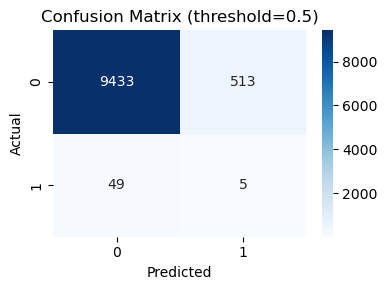

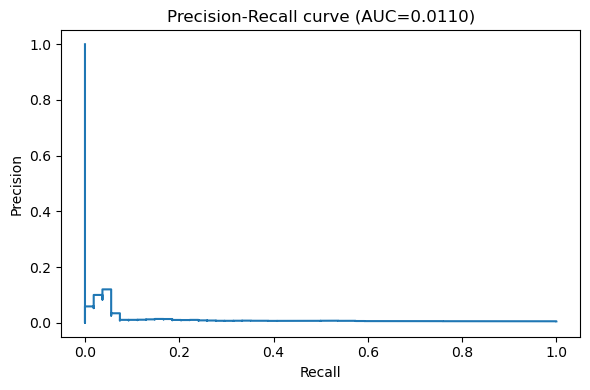


📂 Outputs Saved
Model File   : C:\Users\Admin\Downloads\Internship\Bosch_PMP\models\classification_model.pkl
Metrics File : C:\Users\Admin\Downloads\Internship\Bosch_PMP\models\classification_metrics.json
Confusion Matrix Plot : C:\Users\Admin\Downloads\Internship\Bosch_PMP\reports\figures\confusion_matrix.png
PR Curve Plot        : C:\Users\Admin\Downloads\Internship\Bosch_PMP\reports\figures\precision_recall_curve.png


In [1]:
# ================================
# CLASSIFICATION MODEL 
# ================================

import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, classification_report,
    confusion_matrix, auc
)
from xgboost import XGBClassifier

# -------------------
# Paths
# -------------------
PROJECT_DIR = Path(r"C:\Users\Admin\Downloads\Internship\Bosch_PMP")
PROC_FP = PROJECT_DIR / "data" / "processed" / "bosch_clean.csv"
MODEL_DIR = PROJECT_DIR / "models"
FIG_DIR = PROJECT_DIR / "reports" / "figures"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2

# -------------------
# Delete old outputs if exist
# -------------------
for f in [
    MODEL_DIR / "classification_model.pkl",
    MODEL_DIR / "classification_metrics.json",
    MODEL_DIR / "classification_features.txt",
    FIG_DIR / "confusion_matrix.png",
    FIG_DIR / "precision_recall_curve.png"
]:
    if f.exists():
        f.unlink()
        print(f"Deleted old file: {f.name}")

# -------------------
# Functions
# -------------------
def load_data(path):
    print(f"Loading processed dataset: {path}")
    return pd.read_csv(path, low_memory=False)

def prepare_features(df):
    if "Id" in df.columns:
        df = df.drop(columns=["Id"])
    if "Response" in df.columns and "target" not in df.columns:
        df = df.rename(columns={"Response": "target"})
    y = df["target"].astype(int)
    X = df.drop(columns=["target"])
    X = X.select_dtypes(include=[np.number]).fillna(0)
    return X, y

def train_and_evaluate(X_train, y_train, X_test, y_test):
    pos = y_train.sum()
    neg = len(y_train) - pos
    scale_pos_weight = (neg / (pos + 1e-9)) if pos > 0 else 1.0

    model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.6,
        reg_lambda=1.0,
        tree_method="hist",
        objective="binary:logistic",
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric="auc"
    )

    print("Training XGBoost model...")
    model.fit(X_train, y_train)

    # Probabilities and predictions
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    # Metrics
    metrics = {}
    metrics["roc_auc"] = float(roc_auc_score(y_test, y_prob)) if len(np.unique(y_test)) > 1 else None

    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    metrics["pr_auc"] = float(auc(rec, prec))

    metrics["classification_report"] = classification_report(y_test, y_pred, digits=4, zero_division=0, output_dict=True)
    metrics["confusion_matrix"] = confusion_matrix(y_test, y_pred).tolist()
    metrics["positive_rate_test"] = float(y_test.mean())

    return model, metrics, prec, rec

def save_outputs(model, metrics, X_cols, prec, rec):
    # Save model + metrics
    joblib.dump(model, MODEL_DIR / "classification_model.pkl")
    with open(MODEL_DIR / "classification_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)
    with open(MODEL_DIR / "classification_features.txt", "w") as f:
        for c in X_cols:
            f.write(c + "\n")

    # Confusion matrix plot
    cm = np.array(metrics["confusion_matrix"])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix (threshold=0.5)")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()
    plt.savefig(FIG_DIR / "confusion_matrix.png", dpi=150)
    plt.close()

    # Precision-Recall curve
    plt.figure(figsize=(6, 4))
    plt.step(rec, prec, where='post')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve (AUC=%.4f)" % metrics["pr_auc"])
    plt.tight_layout()
    plt.show()
    plt.savefig(FIG_DIR / "precision_recall_curve.png", dpi=150)
    plt.close()

# -------------------
# Main
# -------------------
def main():
    df = load_data(PROC_FP)
    print("="*60)
    print("✅ Data Loaded")
    print("Shape:", df.shape)
    print("="*60)

    X, y = prepare_features(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    model, metrics, prec, rec = train_and_evaluate(X_train, y_train, X_test, y_test)

    print("\n" + "="*60)
    print("📊 MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"ROC AUC Score : {metrics['roc_auc']:.4f}")
    print(f"PR AUC Score  : {metrics['pr_auc']:.4f}")
    print(f"Positive Rate (test set): {metrics['positive_rate_test']:.4%}")

    # Classification report
    print("\n--- Classification Report ---")
    report_df = pd.DataFrame(metrics["classification_report"]).transpose()
    print(report_df.round(4))

    # Confusion Matrix
    print("\n--- Confusion Matrix (threshold=0.5) ---")
    cm = np.array(metrics["confusion_matrix"])
    print(pd.DataFrame(
        cm,
        index=["Actual 0 (Pass)", "Actual 1 (Fail)"],
        columns=["Pred 0 (Pass)", "Pred 1 (Fail)"]
    ))

    save_outputs(model, metrics, X.columns, prec, rec)

    print("\n" + "="*60)
    print("📂 Outputs Saved")
    print("="*60)
    print(f"Model File   : {MODEL_DIR / 'classification_model.pkl'}")
    print(f"Metrics File : {MODEL_DIR / 'classification_metrics.json'}")
    print(f"Confusion Matrix Plot : {FIG_DIR / 'confusion_matrix.png'}")
    print(f"PR Curve Plot        : {FIG_DIR / 'precision_recall_curve.png'}")
    print("="*60)

if __name__ == "__main__":
    main()
